# Projeto 1

Aluno: <span style="color:red">Luca Mizrahi</span>

Entrega: 16 de maio de 2024

Neste projeto você vai construir um modelo de regressão sobre um dataset de notas finais de alunos do ensino fundamental em relação a parâmetros socio-ambientais dos mesmos. O dataset foi obtido de 
https://archive.ics.uci.edu/dataset/320/student+performance.

## Descrição do projeto

O projeto tem duas partes: modelagem inicial, e modelo com filtragem dos dados.

### Fase 1 

Na parte inicial, você deverá:

- Realizar *feature engineering* conforme necessário
    - Por exemplo: codificar as variáveis categóricas com `OneHotEncoding`
    - Não remova *outliers* aqui: faremos isso na seção seguinte
- Construir três modelos de regressão:
    - Um modelo usando o regressor `DummyRegressor` do scikit-learn (https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyRegressor.html) que vai servir de "regressor trivial" para nós.
    - Um modelo `Ridge`.
    - Um outro modelo qualquer à sua escolha.
    Como o professor é santo, os dois primeiros já estão implementados para você! Então só falta escolher o terceiro.
- Fazer o ajuste de hiperparâmetros dos modelos. O código de exemplo já mostra como fazer o ajuste dos modelos iniciais, você especifica o grid de parâmetros de teste para o seu terceiro modelo.
- Comparar os desempenhos de modelos de modo adequado. Estude o material em https://scikit-learn.org/stable/auto_examples/model_selection/plot_grid_search_stats.html para saber como fazer o teste t com compensação de correlação dos desempenhos dos modelos em um cenário de validação cruzada.
- Escolhido o melhor modelo, treiná-lo no conjunto de treinamento e medir o desempenho no
conjunto de teste, para estimar o desempenho de generalização do modelo.
- Escrever suas conclusões à respeito do que foi aprendido acerta do modelo, por exemplo:
    - Quais as consequências do desempenho do modelo final para a estimação das notas finais?
    - Quais features são mais importantes na determinação da estimativa da nota final? Note que essa pergunta pode ou não ter resposta, dependendo das capacidades dos modelos de regressão que você escolher.

### Fase 2

Agora execute uma filtragem dos dados de treinamento para remover valores anormais. Por exemplo:

- Remova os alunos que tiveram nota final zero
- Remova os alunos que faltaram muito - defina você mesmo o que é "faltar muito"

Refaça o processo da fase 1 para esses dados filtrados.

### Rubrica

Os itens a serem avaliados no projeto são:

FEAT – Fazer feature engineering adequadamente

HYPER – Para cada modelo, fez ajuste de hiperparâmetros adequadamente

MODEL – Treinou e comparou adequadamente os modelos para selecionar o melhor modelo

PERF – Análise de desempenho do modelo. NÃO SERÁ EXIGIDA NENHUMA PERFORMANCE ESPECÍFICA, ISTO NÃO É UMA COMPETIÇÃO DE DESEMPENHO.

FILT - Executar a fase 2: filtragem de dados adequada e repetição do experimento.

- I – Insuficiente

    - Não entregou, ou entregou abobrinha

- D – Em desenvolvimento

    - Faltou um de FEAT, MODEL, PERF

- C – Minimo aceitável

    - Fez FEAT, MODEL, PERF

- B – Esperado

    - Fez FEAT, HYPER, MODEL, PERF

- A – Excepcional

    - Fez FEAT, HYPER, MODEL, PERF, FILT


# Inicio do projeto

## Leitura dos dados e correção de tipos de dados

In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd

<Axes: ylabel='Frequency'>

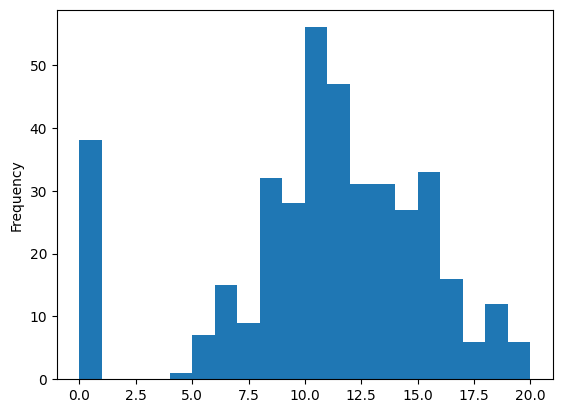

In [2]:
DATA_DIR = Path.cwd()
df_teste = pd.read_csv(DATA_DIR / 'data.csv')
df_teste['grade'].plot(kind='hist', bins=20)

In [3]:
def load_data(data_dir: Path = DATA_DIR) -> pd.DataFrame:
    # Read data and fix column types.
    df = pd.read_csv(data_dir / 'data.csv')

    categorical_columns = [
        'school',
        'sex',
        'address',
        'famsize',
        'Pstatus',
        'Mjob',
        'Fjob',
        'reason',
        'guardian',
        'schoolsup',
        'famsup',
        'paid',
        'activities',
        'nursery',
        'higher',
        'internet',
        'romantic',
    ]
    numerical_columns = [
        'age',
        'absences',
        'grade',
    ]
    ordinal_columns = [
        'Medu',
        'Fedu',
        'traveltime',
        'studytime',
        'failures',
        'famrel',
        'freetime',
        'goout',
        'Dalc',
        'Walc',
        'health',
    ]
    for column_group, column_type in (
        (categorical_columns, 'category'),
        (numerical_columns, 'float64'),
        (ordinal_columns, 'int64'),
    ):
        for column in column_group:
            df[column] = df[column].astype(column_type)

    # Split features and target, and return.
    X = df.drop(columns=['grade']).copy()
    y = df['grade'].copy()
    return X, y

In [4]:
X, y = load_data()


## Visualização simples dos dados

Chamar isso de análise exploratória é vexatório...

In [5]:
def make_barplots(X: pd.DataFrame, y: pd.Series) -> None:
    fig, axes = plt.subplots(10, 3, figsize=(12, 45))
    axes = axes.flatten()

    fig.tight_layout(h_pad=8, w_pad=5)

    for index, (column_name, column_series) in enumerate(X.items()):
        column_series \
            .value_counts() \
            .sort_index(ascending=False) \
            .plot \
            .barh(ax=axes[index])
        axes[index].set_title(column_name)

    fig.suptitle('Barplots of Categorical and Ordinal Features', fontsize=16)
    fig.subplots_adjust(top=0.96)
    plt.show()

    plt.figure(figsize=(3, 4))
    y.plot.hist(bins=20, edgecolor='black')
    plt.title('Histogram of Target')
    plt.show()

In [6]:
def make_boxplots(X: pd.DataFrame, y: pd.Series) -> None:
    df = pd.concat([X, y], axis=1)

    fig, axes = plt.subplots(10, 3, figsize=(12, 45))
    axes = axes.flatten()

    fig.tight_layout(h_pad=8, w_pad=5)

    for index, column in enumerate(X.columns):
        ax = axes[index]
        bp_objs = df.boxplot(
            by=['school', column],
            column='grade',
            ax=ax,
            rot=45,
            fontsize=8,
            return_type='dict',
            patch_artist=True,
        )
        boxes = bp_objs['grade']['boxes']
        box_colors = [
            'lightgreen' if '(GP,' in tick.get_text() else 'lightblue'
            for tick in ax.get_xticklabels()
        ]
        for box, color in zip(boxes, box_colors):
            box.set_facecolor(color)
        ax.set_title(column)
        ax.set_xlabel('')
    fig.suptitle('Grade distribution by feature and school', fontsize=16)
    fig.subplots_adjust(top=0.96)
    plt.show()

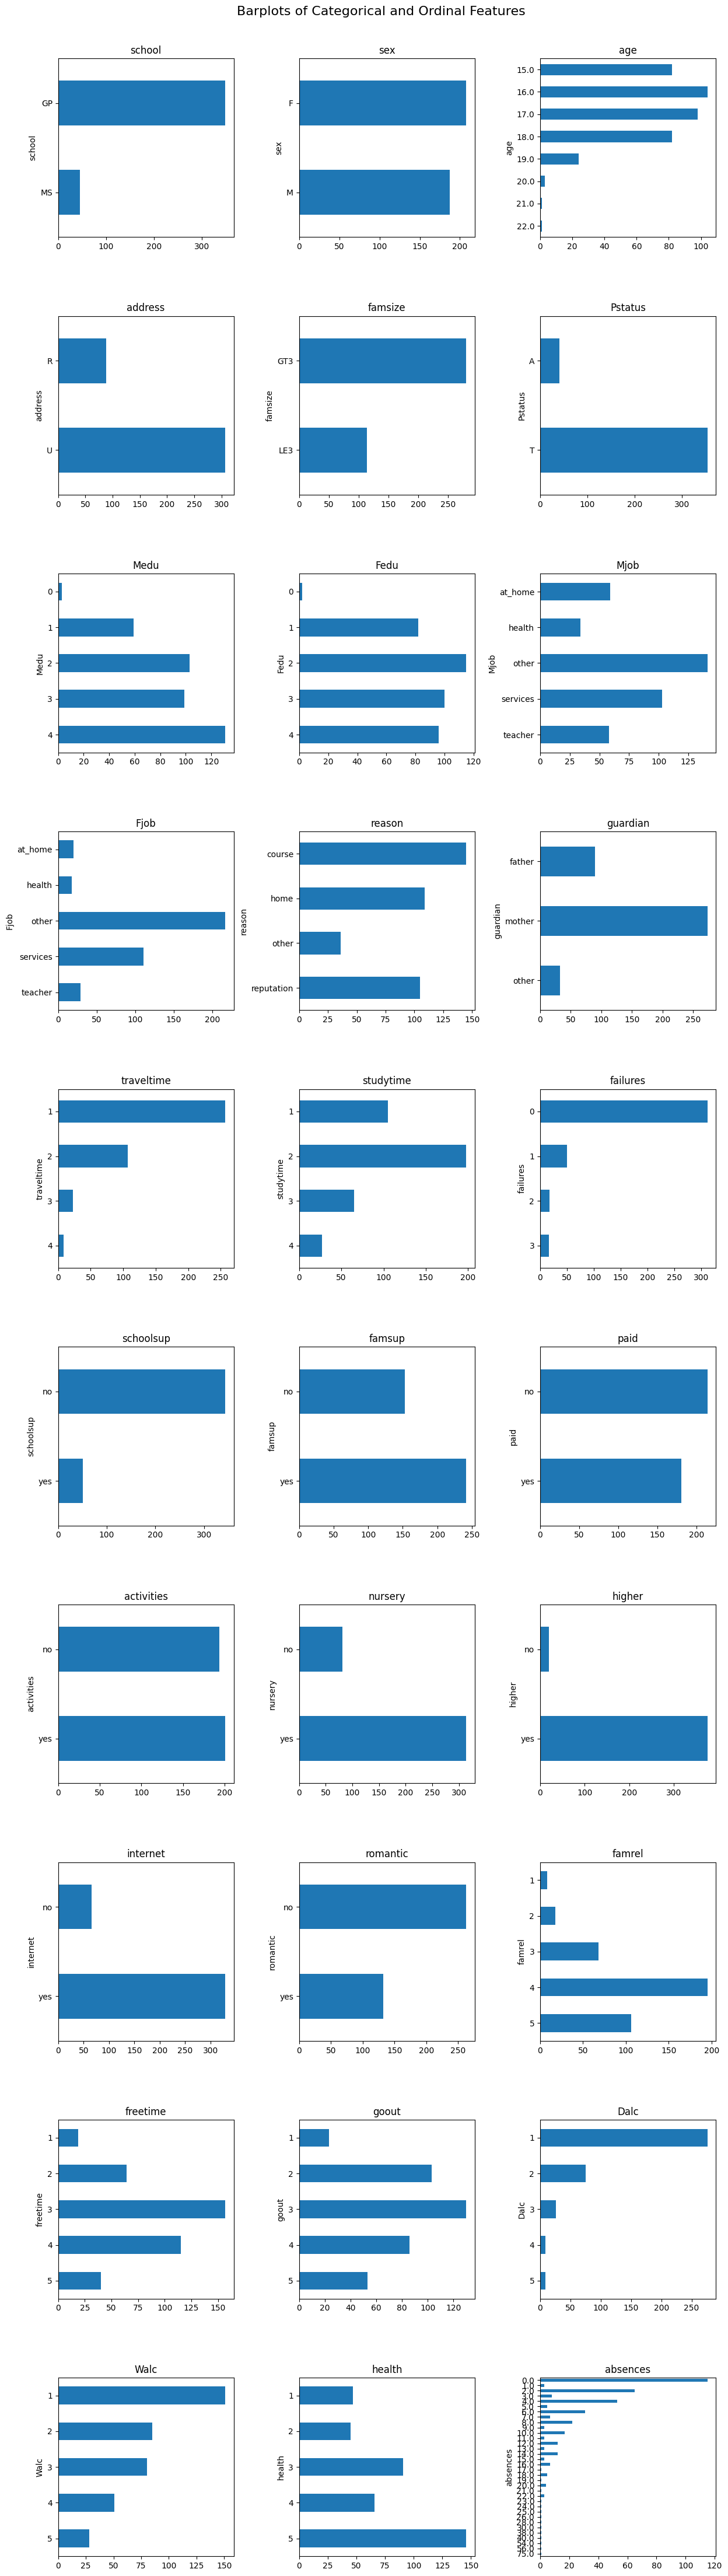

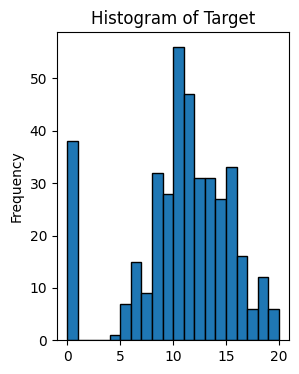

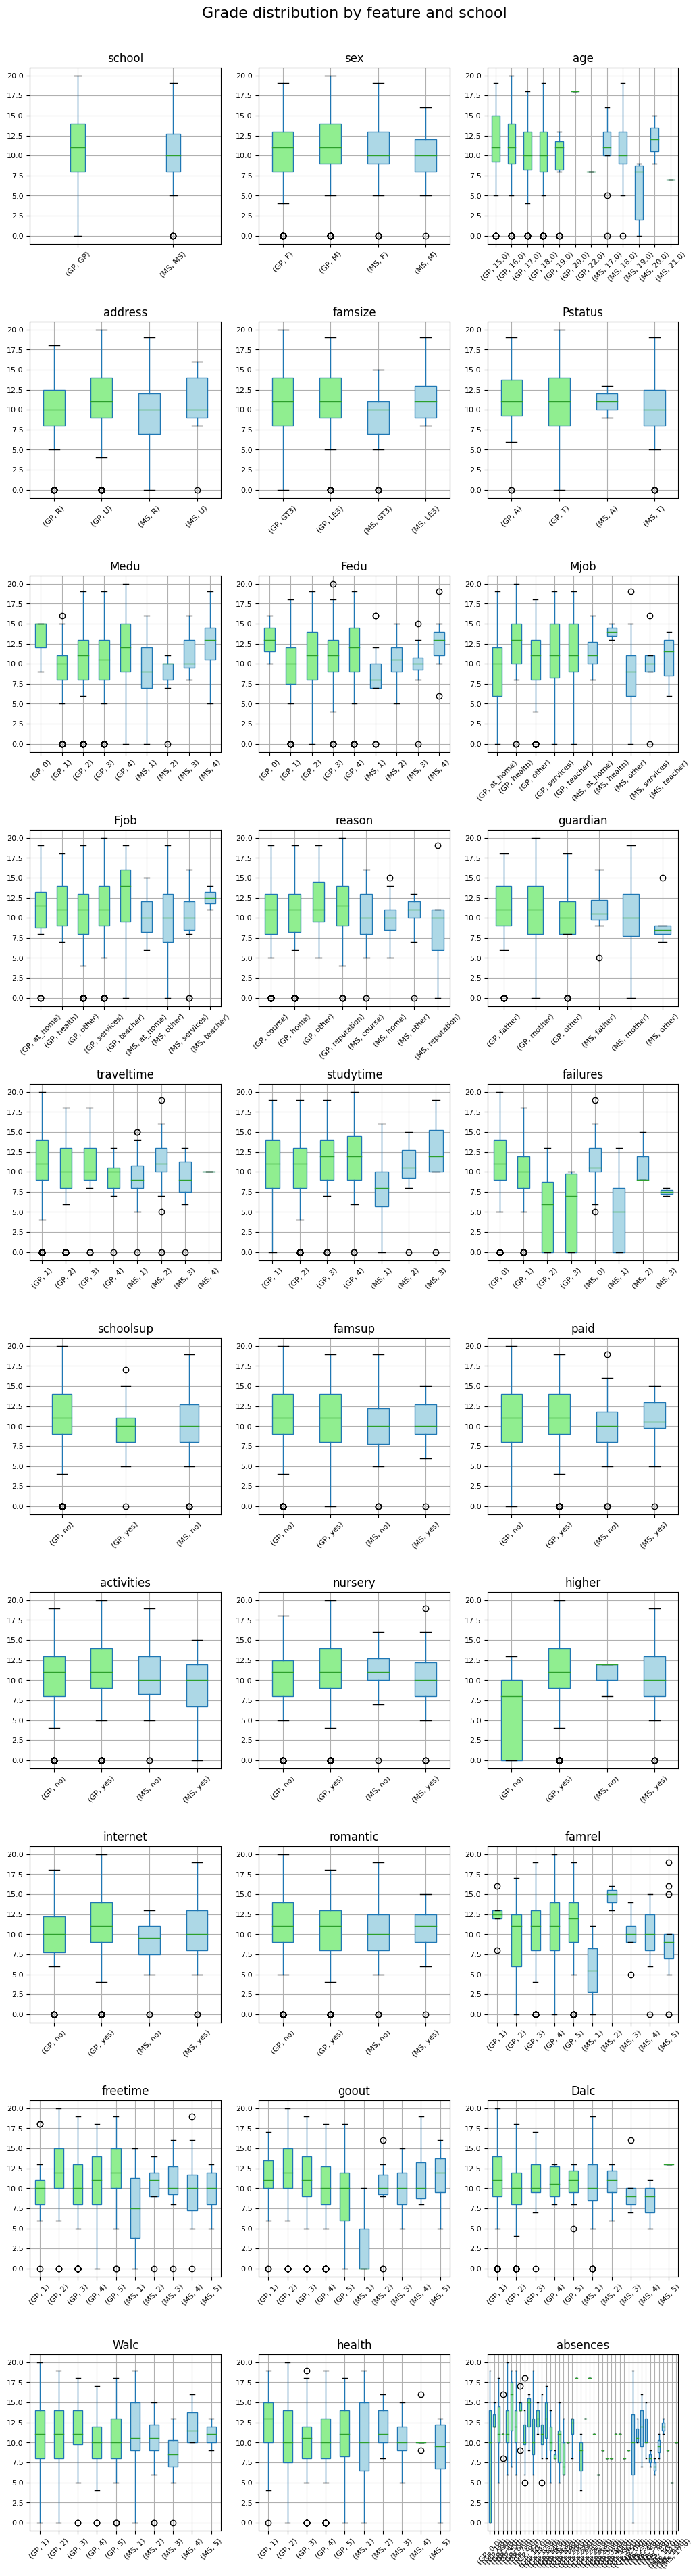

In [7]:
make_barplots(X, y)
make_boxplots(X, y)

## Separação treino-teste e modelagem inicial

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
)

In [9]:
import numpy as np

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.dummy import DummyRegressor
from sklearn.impute import SimpleImputer

### FEAT - Feature Engineering

- Utilizando OneHotEncoding para as variáveis categóricas 

- Utilizando StandardScaler e SimpleImputer para as variáveis numéricas

- Sem remoção de outliers

In [10]:
categorical_features = X.select_dtypes(include=['category']).columns
numerical_features = X.select_dtypes(include=['float64', 'int64']).columns

num_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('poly', PolynomialFeatures(degree=2, include_bias=False)), 
    # ('imputer', SimpleImputer(strategy='median')),
])

cat_pipeline = Pipeline([
    ('encoder', OneHotEncoder(drop='first')),
])

preprocessing_pipeline = ColumnTransformer(
    transformers=[
        ('num', num_pipeline, numerical_features),
        ('cat', cat_pipeline, categorical_features),
    ],
    remainder='passthrough',
)

pipe = Pipeline([
    ('preprocessor', preprocessing_pipeline),
    ('regressor', DummyRegressor(strategy='mean')),
])

### HYPER - Ajuste de hiperparâmetros para os 3 modelos implementados (Dummy, Ridge e RandomForest)

- Dummy: sem hiperparâmetros

- Ridge: alpha

- RandomForest: n_estimators, max_depth

A estimativa dos melhores hiperparâmetros será feita utilizando *GridSearchCV* e um numero de splits de **100** (para garantir que o modelo rode em um tempo razoável)

In [11]:
from sklearn.model_selection import GridSearchCV, ShuffleSplit
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor

# Quanto maior o numero de splits, maior a significância estatística da
# validação cruzada, mas também maior o tempo de execução.
num_splits = 100

# Modelos que serão testados
param_grid = [
    {
        'regressor': [DummyRegressor(strategy='mean')],
    },
    {
        'regressor': [Ridge()],
        'regressor__alpha': np.logspace(-3, 3, 7),
    },
    {
        'regressor': [RandomForestRegressor(random_state=42)],
        'regressor__n_estimators': [100, 200, 500],
        'regressor__max_depth': [5, 10, None],
    },
]

test_fraction = 0.2
num_samples_total = len(y_train)
num_samples_test = int(test_fraction * num_samples_total)
num_samples_train = num_samples_total - num_samples_test

grid = GridSearchCV(
    pipe,
    param_grid,
    cv=ShuffleSplit(
        n_splits=num_splits,
        test_size=num_samples_test,
        random_state=42,
    ),
    n_jobs=-1,
    scoring='neg_root_mean_squared_error',
)

# Treinando os modelos do grid search
grid.fit(X_train, y_train)

# Exibindo o melhor modelo encontrado
print(f'Melhor modelo: {grid.best_estimator_}')

Melhor modelo: Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler()),
                                                                  ('poly',
                                                                   PolynomialFeatures(include_bias=False))]),
                                                  Index(['age', 'Medu', 'Fedu', 'traveltime', 'studytime', 'failures', 'famrel',
       'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(drop='first'))]),
                                 

In [12]:
results_df = pd.DataFrame(grid.cv_results_) \
    .sort_values(by='rank_test_score')

results_df = results_df \
    .set_index(
        results_df["params"] \
            .apply(lambda x: "_".join(str(val) for val in x.values()))
    ) \
    .rename_axis("model")

model_scores = results_df.filter(regex=r"split\d*_test_score")

In [13]:
print(f'O melhor modelo dentre os modelos utilizadas: {model_scores.index[0]}')
print(f'O pior modelo dentre os modelos utilizadas: {model_scores.index[-1]}')

O melhor modelo dentre os modelos utilizadas: RandomForestRegressor(random_state=42)_5_500
O pior modelo dentre os modelos utilizadas: Ridge()_0.001


In [14]:
# Comparação das médias e desvios padrão dos modelos testados com diferentes parâmetros
mean_perf = model_scores.agg(['mean', 'std'], axis=1)
mean_perf['std'] = mean_perf['std'] / np.sqrt(num_splits)
mean_perf = mean_perf.sort_values('mean', ascending=False)
mean_perf

,mean,std
model,,
RandomForestRegressor(random_state=42)_5_500,-4.057904,0.035281
RandomForestRegressor(random_state=42)_5_200,-4.064603,0.035060
RandomForestRegressor(random_state=42)_5_100,-4.071317,0.035198
RandomForestRegressor(random_state=42)_10_500,-4.075895,0.035925
RandomForestRegressor(random_state=42)_None_500,-4.078105,0.036167
RandomForestRegressor(random_state=42)_10_200,-4.084417,0.035606
RandomForestRegressor(random_state=42)_None_200,-4.087154,0.035727
RandomForestRegressor(random_state=42)_10_100,-4.093899,0.035672
RandomForestRegressor(random_state=42)_None_100,-4.099509,0.035826


### MODEL - Comparação de modelos

O código a seguir foi copiado de https://scikit-learn.org/stable/auto_examples/model_selection/plot_grid_search_stats.html

In [15]:
import numpy as np

from scipy.stats import t


def corrected_std(differences, n_train, n_test):
    """Corrects standard deviation using Nadeau and Bengio's approach.

    Parameters
    ----------
    differences : ndarray of shape (n_samples,)
        Vector containing the differences in the score metrics of two models.
    n_train : int
        Number of samples in the training set.
    n_test : int
        Number of samples in the testing set.

    Returns
    -------
    corrected_std : float
        Variance-corrected standard deviation of the set of differences.
    """
    # kr = k times r, r times repeated k-fold crossvalidation,
    # kr equals the number of times the model was evaluated
    kr = len(differences)
    corrected_var = np.var(differences, ddof=1) * (1 / kr + n_test / n_train)
    corrected_std = np.sqrt(corrected_var)
    return corrected_std


def compute_corrected_ttest(differences, df, n_train, n_test):
    """Computes right-tailed paired t-test with corrected variance.

    Parameters
    ----------
    differences : array-like of shape (n_samples,)
        Vector containing the differences in the score metrics of two models.
    df : int
        Degrees of freedom.
    n_train : int
        Number of samples in the training set.
    n_test : int
        Number of samples in the testing set.

    Returns
    -------
    t_stat : float
        Variance-corrected t-statistic.
    p_val : float
        Variance-corrected p-value.
    """
    mean = np.mean(differences)
    std = corrected_std(differences, n_train, n_test)
    t_stat = mean / std
    p_val = t.sf(np.abs(t_stat), df)  # right-tailed t-test
    return t_stat, p_val

In [16]:
print(f'Melhor modelo de random forest: {model_scores.index[0]}')
print(f'Melhor modelo de ridge: {model_scores.index[9]}')
print(f'Pior Modelo: {model_scores.index[-1]}')

Melhor modelo de random forest: RandomForestRegressor(random_state=42)_5_500
Melhor modelo de ridge: Ridge()_1000.0
Pior Modelo: Ridge()_0.001


In [17]:
model_1_scores = model_scores.iloc[0].values  # scores of the best model (Random Forest)
model_2_scores = model_scores.iloc[9].values  # scores of the best Ridge model

differences = model_1_scores - model_2_scores

n = differences.shape[0]  # number of test sets
dof = n - 1

# Comparação dos modelos utilizando o teste t corrigido 
t_stat, p_val = compute_corrected_ttest(
    differences,
    dof,
    num_samples_train,
    num_samples_test,
)

# Random Forest (Best Model) vs Dummy Regressor (Worst Model) 
print(f"Corrected t-statistic: {t_stat:.3f}")
print(f"Corrected p-value: {p_val:.3f}\n")
print(f'O teste t corrigido indica que o modelo Random Forest é melhor que o melhor Ridge com significância estatística dado que {p_val:.4f} < 0.05.')

Corrected t-statistic: 2.759
Corrected p-value: 0.003

O teste t corrigido indica que o modelo Random Forest é melhor que o melhor Ridge com significância estatística dado que 0.0035 < 0.05.


In [18]:
model_1_scores = model_scores.iloc[0].values  # scores of the best model (Random Forest)
model_2_scores = model_scores.iloc[-1].values  # scores of the worst model (Dummy Regressor)

differences = model_1_scores - model_2_scores

n = differences.shape[0]  # number of test sets
dof = n - 1

t_stat, p_val = compute_corrected_ttest(
    differences,
    dof,
    num_samples_train,
    num_samples_test,
)

# Random Forest (Best Model) vs Ridge 
print(f"Corrected t-statistic: {t_stat:.3f}")
print(f"Corrected p-value: {p_val:.3f}\n")
print(f"O teste t corrigido indica que o modelo Random Forest é melhor que o pior modelo com significância estatística dado que {p_val:.4f} < 0.05.")


Corrected t-statistic: 7.233
Corrected p-value: 0.000

O teste t corrigido indica que o modelo Random Forest é melhor que o pior modelo com significância estatística dado que 0.0000 < 0.05.


In [19]:
# Test all models against the best model.
best_model_scores = model_scores.iloc[0].values

n_comparisons = model_scores.shape[0] - 1

pairwise_t_test = []

for model_i in range(1, len(model_scores)):
    model_i_scores = model_scores.iloc[model_i].values
    differences = model_i_scores - best_model_scores
    t_stat, p_val = compute_corrected_ttest(
        differences,
        dof,
        num_samples_train,
        num_samples_test,
    )

    # Implement Bonferroni correction
    p_val *= n_comparisons

    # Bonferroni can output p-values higher than 1
    p_val = 1 if p_val > 1 else p_val

    pairwise_t_test.append([
        model_scores.index[0],
        model_scores.index[model_i],
        t_stat,
        p_val,
    ])

pairwise_comp_df = pd.DataFrame(
    pairwise_t_test,
    columns=["model_1", "model_2", "t_stat", "p_val"],
).round(3)

In [20]:
pairwise_comp_df

,model_1,model_2,t_stat,p_val
0,RandomForestRegressor(random_state=42)_5_500,RandomForestRegressor(random_state=42)_5_200,-0.489,1.000
1,RandomForestRegressor(random_state=42)_5_500,RandomForestRegressor(random_state=42)_5_100,-0.673,1.000
2,RandomForestRegressor(random_state=42)_5_500,RandomForestRegressor(random_state=42)_10_500,-0.703,1.000
3,RandomForestRegressor(random_state=42)_5_500,RandomForestRegressor(random_state=42)_None_500,-0.728,1.000
4,RandomForestRegressor(random_state=42)_5_500,RandomForestRegressor(random_state=42)_10_200,-0.906,1.000
5,RandomForestRegressor(random_state=42)_5_500,RandomForestRegressor(random_state=42)_None_200,-0.964,1.000
6,RandomForestRegressor(random_state=42)_5_500,RandomForestRegressor(random_state=42)_10_100,-1.040,1.000
7,RandomForestRegressor(random_state=42)_5_500,RandomForestRegressor(random_state=42)_None_100,-1.180,1.000
8,RandomForestRegressor(random_state=42)_5_500,Ridge()_1000.0,-2.759,0.055
9,RandomForestRegressor(random_state=42)_5_500,DummyRegressor(),-3.871,0.002


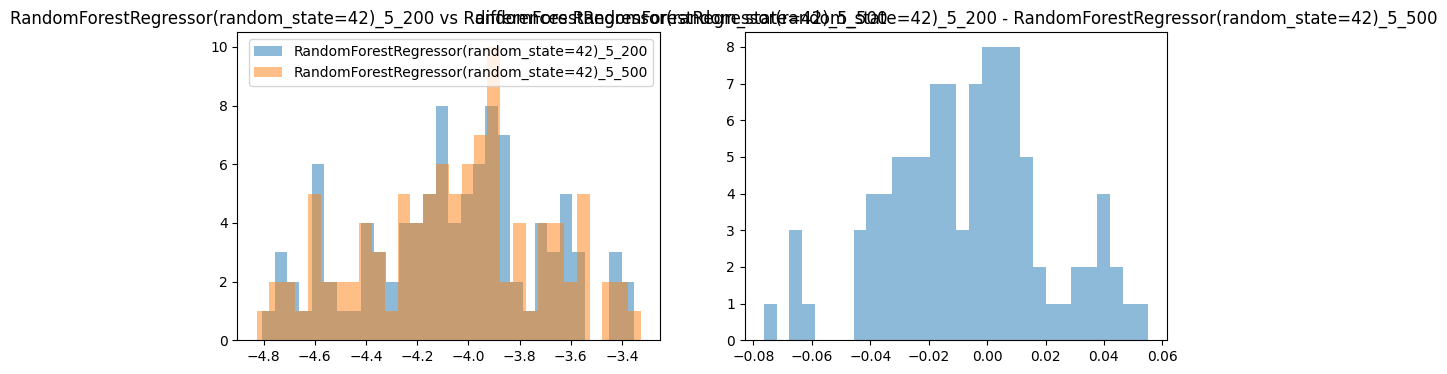

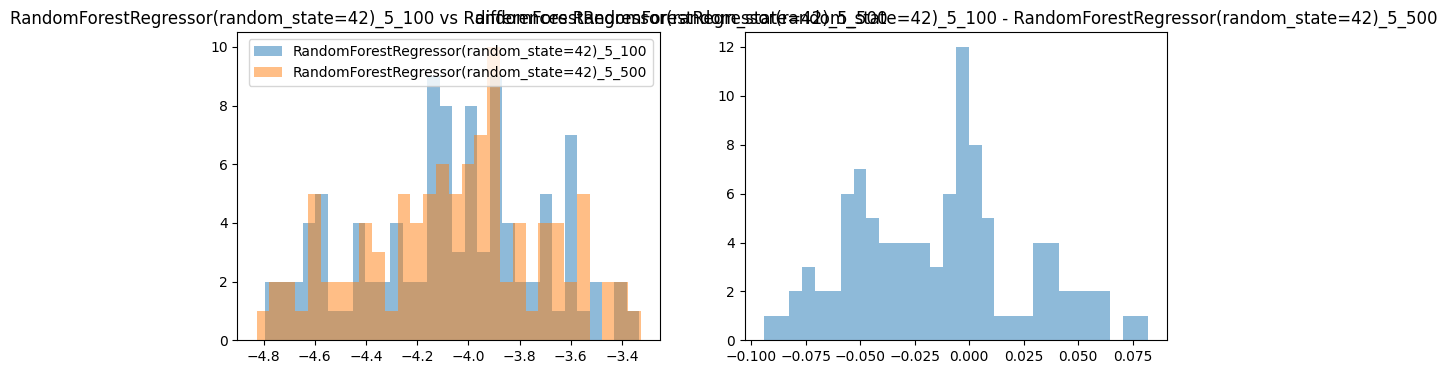

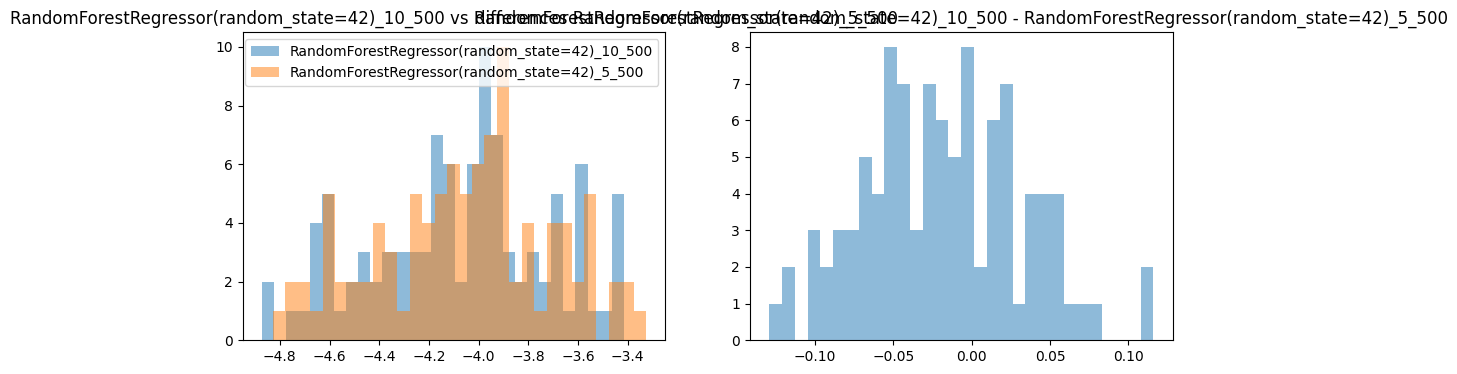

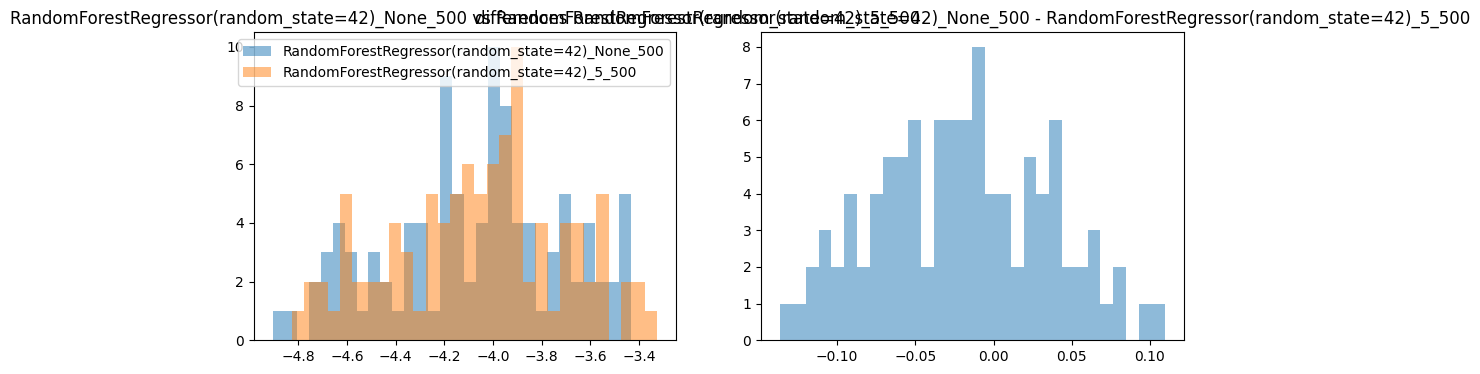

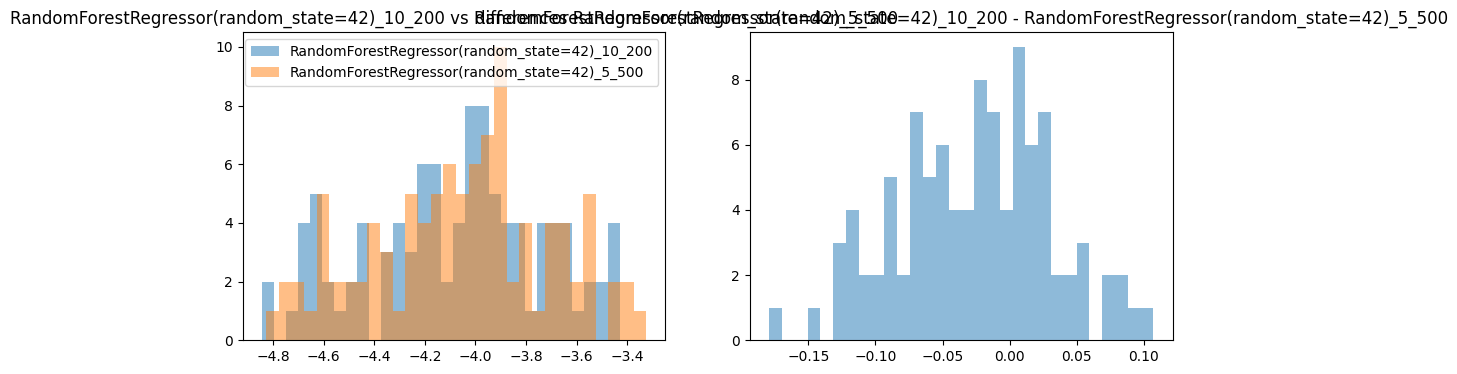

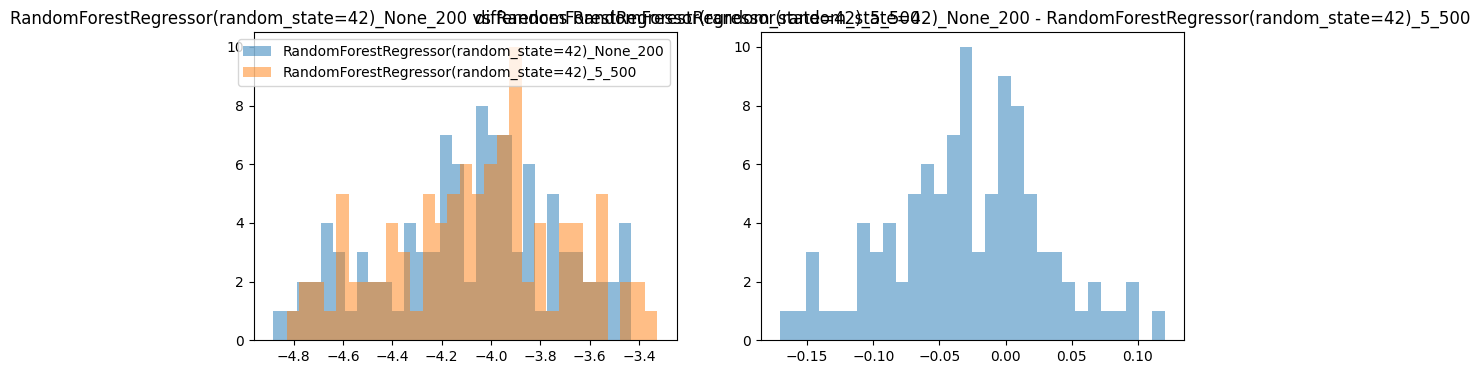

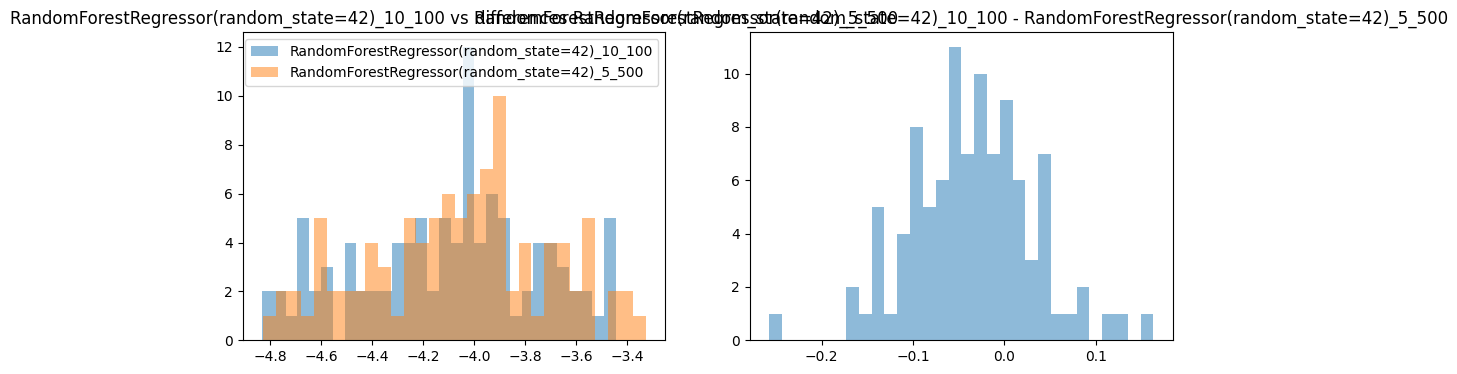

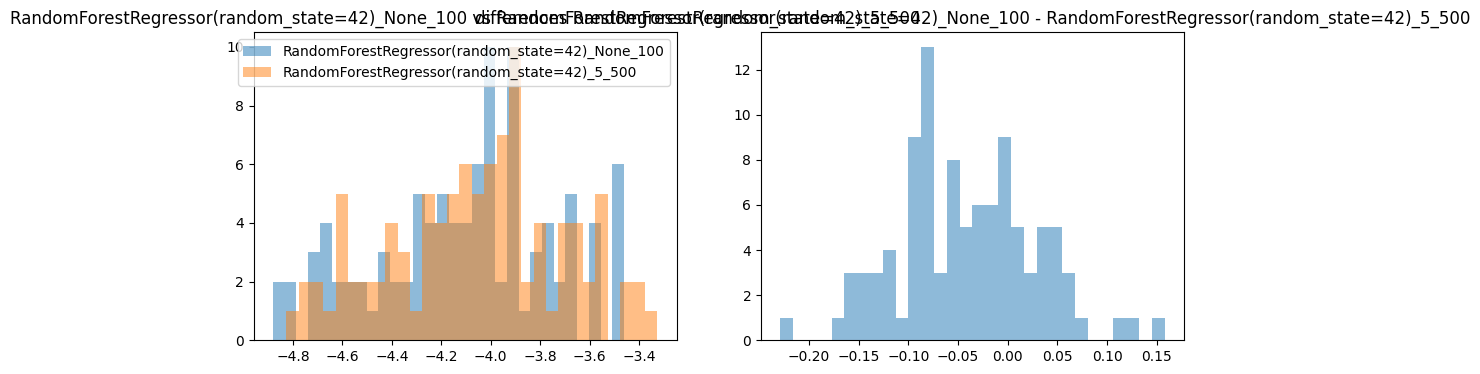

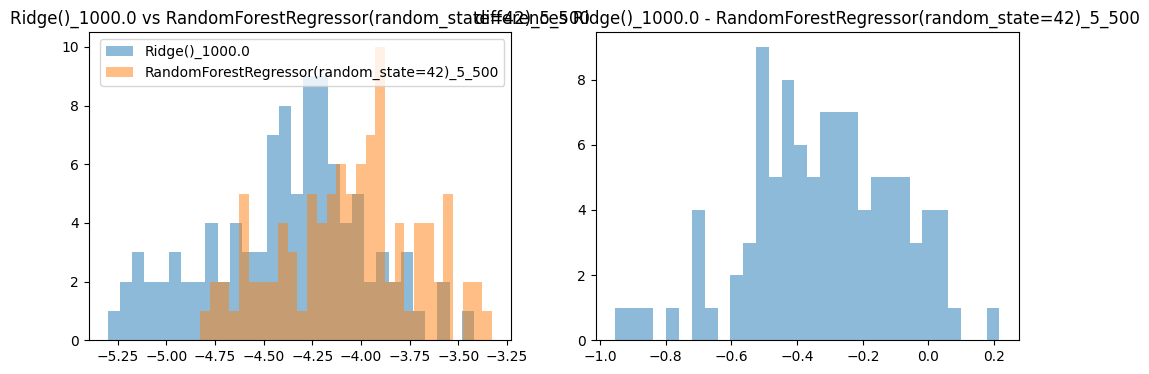

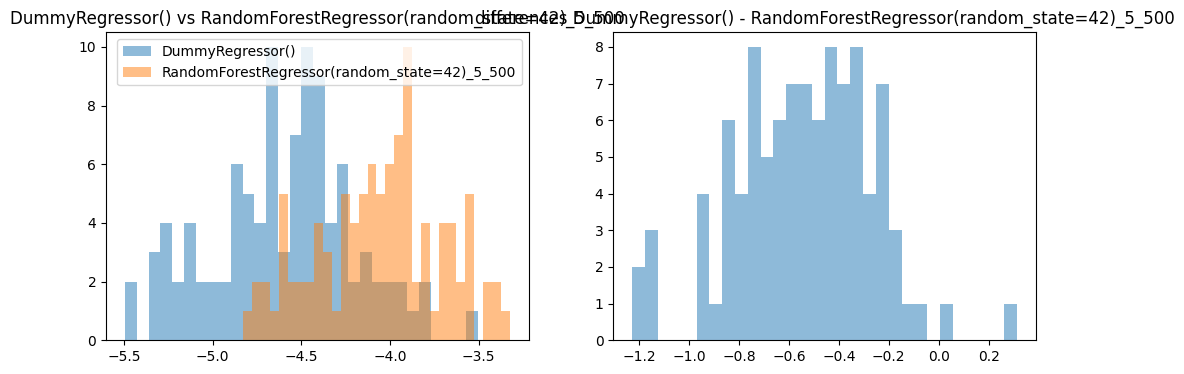

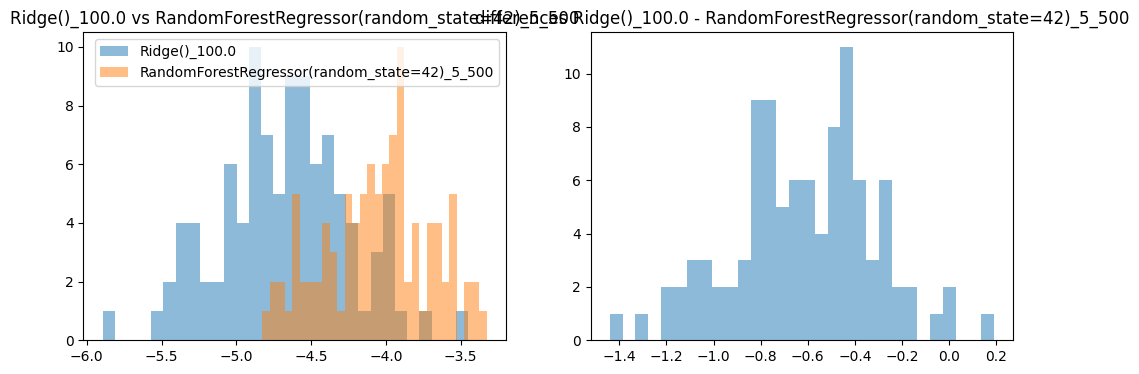

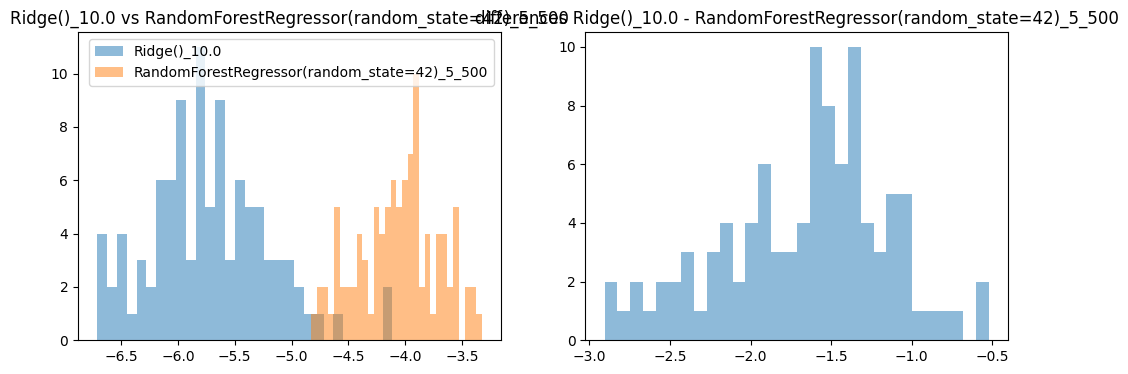

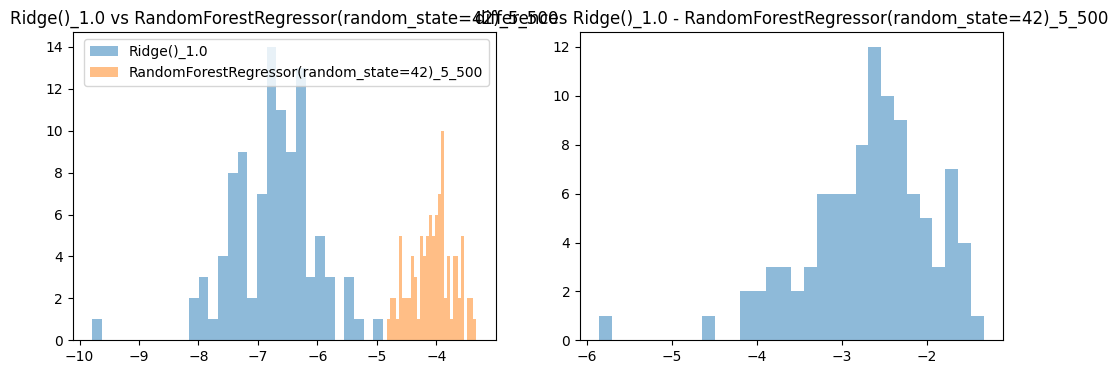

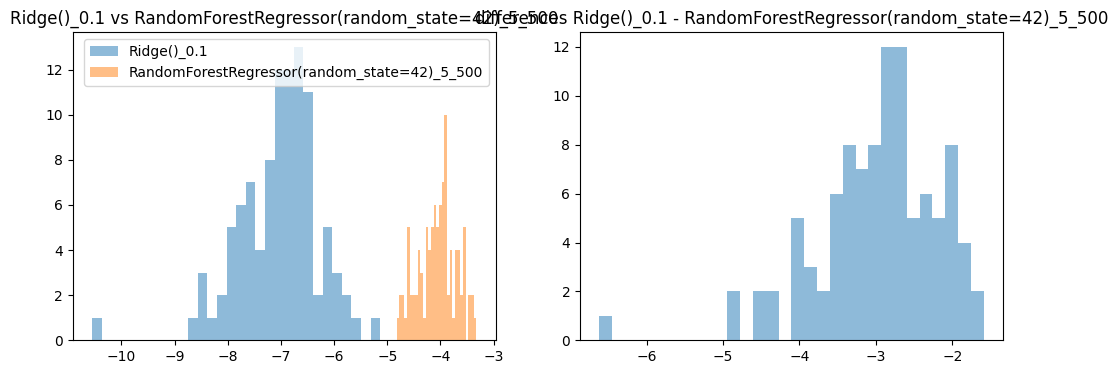

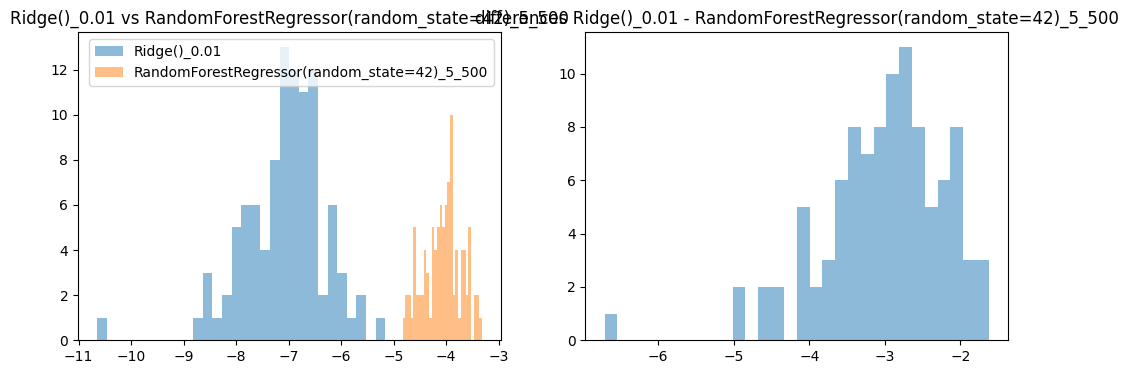

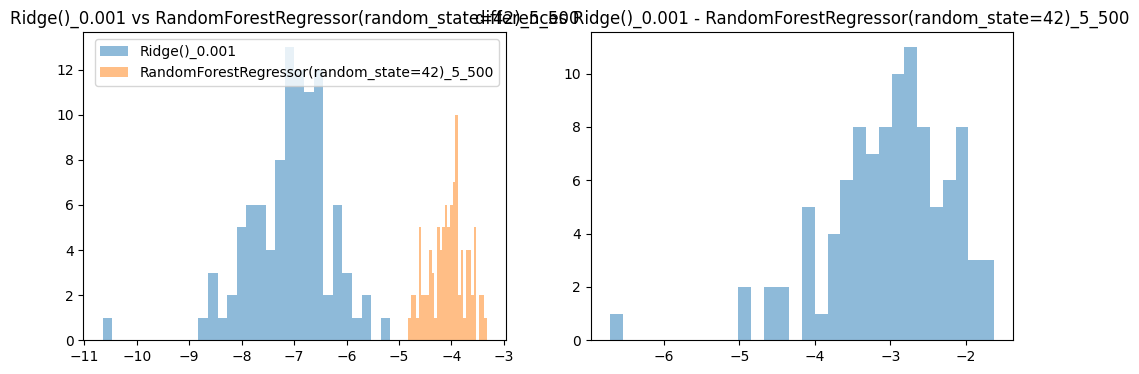

In [21]:
for model_i in range(1, len(model_scores)):
    model_i_scores = model_scores.iloc[model_i].values
    differences = model_i_scores - best_model_scores

    name_i = model_scores.index[model_i]
    name_best = model_scores.index[0]

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.hist(model_i_scores, bins=30, alpha=0.5, label=name_i)
    plt.hist(best_model_scores, bins=30, alpha=0.5, label=name_best)
    plt.title(f'{name_i} vs {name_best}')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.hist(differences, bins=30, alpha=0.5)
    plt.title(f'differences {name_i} - {name_best}')
    plt.show()

### PERF - Teste de Desempenho do melhor modelo no conjunto de Teste

De acordo com o cross-validation, utilizando o teste t com compensação de correlação dos desempenhos dos modelos, o modelo escolhido foi o RandomForestRegressor com os hiperparâmetros n_estimators=500 e max_depth=5.

In [22]:
# Treine RandomForest com os melhores parâmetros encontrados
best_rf_params = {
    'n_estimators': 500,
    'max_depth': 5,
    'random_state': 42,
}

from sklearn.ensemble import RandomForestRegressor

best_rf = RandomForestRegressor(**best_rf_params)

# Pipeline de pré-processamento final
pipe = Pipeline([
    ('preprocessor', preprocessing_pipeline),
    ('regressor', best_rf)
])

# Treinar o modelo no conjunto de treino completo
pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler()),
                                                                  ('poly',
                                                                   PolynomialFeatures(include_bias=False))]),
                                                  Index(['age', 'Medu', 'Fedu', 'traveltime', 'studytime', 'failures', 'famrel',
       'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(drop='first'))]),
                                                  Index(['school', 'sex', 'address', 'famsize', 'Pstatus', 'Mjob', 'Fjob',
       'reason', 'guardian', 'schoolsup', 'famsup', 'paid', 'activities',
       'nursery', 'higher', 'internet', 'romantic'],
      dtype='object'))])),
                ('regressor',
                 RandomForestRegressor(max_depth=5, n_estimators=500,
                                       random_state=42))])

In [23]:
# Avaliação do modelo no conjunto de teste
from sklearn.metrics import mean_squared_error, r2_score

# Prever no conjunto de teste
y_pred_test = pipe.predict(X_test)

# Função para calcular as métricas
def compute_metrics(y_true, y_pred):
    return {
        "RMSE": np.sqrt(mean_squared_error(y_true, y_pred)),
        "R²": r2_score(y_true, y_pred)
    }

# Métricas de desempenho no conjunto de teste
test_metrics_before = compute_metrics(y_test, y_pred_test)

print("Desempenho no Conjunto de Teste:")
print(f"RMSE: {test_metrics_before['RMSE']:.3f}")

Desempenho no Conjunto de Teste:
RMSE: 3.974


In [24]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestRegressor

# Obter o regressor RandomForest do pipeline
random_forest_model = pipe.named_steps['regressor']

# Obter as importâncias das features do modelo treinado
feature_importances = random_forest_model.feature_importances_

# Preparar os nomes das features após a transformação
feature_names_num = pipe.named_steps['preprocessor'].transformers_[0][1].named_steps['poly'].get_feature_names_out(input_features=numerical_features)
feature_names_cat = pipe.named_steps['preprocessor'].named_transformers_['cat'].named_steps['encoder'].get_feature_names_out(categorical_features)

# Combinar todos os nomes das features numéricas e categóricas
all_features = np.concatenate([feature_names_num, feature_names_cat])

# Verificar se o número de importâncias corresponde ao número de nomes de features
if len(all_features) != len(feature_importances):
    raise ValueError("O número de features não coincide com o número de importâncias de features.")

# Ordenar as features pela importância
indices = np.argsort(feature_importances)[::-1]

# print das importâncias das features com os nomes das features
for i in range(len(all_features)):
    print(f'Feature: {all_features[indices[i]]}, Importância: {feature_importances[indices[i]]}')

# Plotar as importâncias das features
# plt.figure(figsize=(10, 8))
# plt.title("Importância das Features no Modelo RandomForest")
# plt.barh(all_features[indices], feature_importances[indices], color='b', align='center')
# plt.xlabel("Importância")
# plt.ylabel("Feature")
# plt.gca().invert_yaxis()  # Inverte o eixo y para mostrar a feature mais importante no topo
# plt.show()

Feature: failures absences, Importância: 0.24632785179709377
Feature: absences, Importância: 0.08747721218037431
Feature: traveltime absences, Importância: 0.03182024715525128
Feature: age absences, Importância: 0.026638626562770513
Feature: freetime health, Importância: 0.022134143379317347
Feature: studytime goout, Importância: 0.019224757012996904
Feature: age health, Importância: 0.0172519965646012
Feature: studytime famrel, Importância: 0.016788501916421998
Feature: age traveltime, Importância: 0.016751172290530605
Feature: Medu failures, Importância: 0.01567243873817434
Feature: age Fedu, Importância: 0.015564381589354411
Feature: Walc health, Importância: 0.014696890045975412
Feature: famrel goout, Importância: 0.014182350948169244
Feature: goout absences, Importância: 0.012782023388019316
Feature: goout Walc, Importância: 0.012662293284478853
Feature: Medu absences, Importância: 0.011578494380701715
Feature: studytime absences, Importância: 0.011101281108427499
Feature: age stu

### Conclusões sobre o modelo

- Desempenho

O modelo escolhido foi o RandomForestRegressor, que obteve um desempenho superior aos outros 2 modelos implementados (Dummy e Ridge). No entanto, o desempenho do modelo não foi muito bom, já que apresentou um erro médio de **3.974 pontos** nas notas finais previstas, o que é um erro considerável considerando que as notas finais variam de 0 a 20. 

- Importância das features

Realizando uma análise das features mais importantes para o modelo escolhido, é possível observar que 2 features se destacam: "Absences" e "failures", respectivamente. Isso indica que a quantidade de faltas e reprovações anteriores são as features mais importantes para a determinação da nota final dos alunos.

## Fase 2

Removendo os alunos que tiveram nota final zero e os alunos que faltaram mais de 2 desvios padrão da média de faltas.

Original size: 395, After filtering: 346
Axes(0.125,0.11;0.775x0.77)


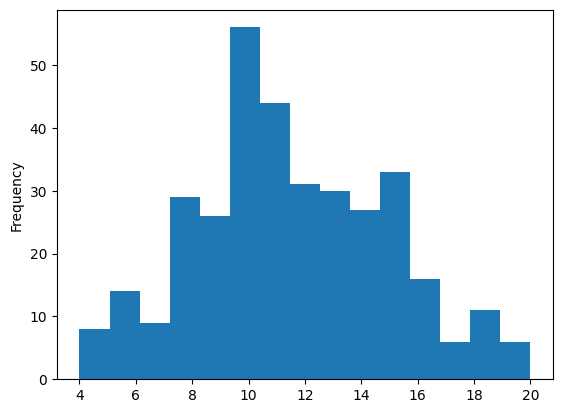

In [25]:
# Carregar os dados (substitua 'your_data.csv' pelo caminho correto do seu arquivo)
df = pd.read_csv('data.csv')

# Filtrar alunos com nota final zero
df_filtered = df[df['grade'] > 0]

# Calcular a média e o desvio padrão das faltas
mean_absences = df_filtered['absences'].mean()
std_absences = df_filtered['absences'].std()

# Definir "faltar muito" como faltas acima de 2 desvios padrão da média
threshold_absences = mean_absences + 2 * std_absences
df_filtered = df_filtered[df_filtered['absences'] <= threshold_absences]

# Verificar o tamanho do dataset antes e depois da filtragem
print(f"Original size: {len(df)}, After filtering: {len(df_filtered)}")

# Plotar o histograma das notas finais
print(df_filtered['grade'].plot(kind='hist', bins=15))



In [26]:
# Re-encontra o melhor modelo para os novos dados
# Quanto maior o numero de splits, maior a significância estatística da
# validação cruzada, mas também maior o tempo de execução.

# Novo X e Y
# Dividir os dados filtrados em treino e teste
X = df_filtered.drop('grade', axis=1)
y = df_filtered['grade']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Modelos que serão testados
num_splits = 100

# Modelos que serão testados
param_grid = [
    {
        'regressor': [DummyRegressor(strategy='mean')],
    },
    {
        'regressor': [Ridge()],
        'regressor__alpha': np.logspace(-3, 3, 7),
    },
    {
        'regressor': [RandomForestRegressor(random_state=42)],
        'regressor__n_estimators': [100, 200, 500],
        'regressor__max_depth': [5, 10, None],
    },
]

test_fraction = 0.2
num_samples_total = len(y_train)
num_samples_test = int(test_fraction * num_samples_total)
num_samples_train = num_samples_total - num_samples_test

grid = GridSearchCV(
    pipe,
    param_grid,
    cv=ShuffleSplit(
        n_splits=num_splits,
        test_size=num_samples_test,
        random_state=42,
    ),
    n_jobs=-1,
    scoring='neg_root_mean_squared_error',
)

# Treinando os modelos do grid search
grid.fit(X_train, y_train)

# Exibindo o melhor modelo encontrado
print(f'Melhor modelo: {grid.best_estimator_}')

Melhor modelo: Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler()),
                                                                  ('poly',
                                                                   PolynomialFeatures(include_bias=False))]),
                                                  Index(['age', 'Medu', 'Fedu', 'traveltime', 'studytime', 'failures', 'famrel',
       'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(drop='first'))]),
                                 

In [27]:
results_df = pd.DataFrame(grid.cv_results_) \
    .sort_values(by='rank_test_score')

results_df = results_df \
    .set_index(
        results_df["params"] \
            .apply(lambda x: "_".join(str(val) for val in x.values()))
    ) \
    .rename_axis("model")

model_scores = results_df.filter(regex=r"split\d*_test_score")

In [28]:
print(f'O melhor modelo dentre os modelos utilizadas: {model_scores.index[0]}')
print(f'O pior modelo dentre os modelos utilizadas: {model_scores.index[-1]}')

O melhor modelo dentre os modelos utilizadas: RandomForestRegressor(random_state=42)_None_200
O pior modelo dentre os modelos utilizadas: Ridge()_0.001


In [29]:
# Comparação das médias e desvios padrão dos modelos testados com diferentes parâmetros
mean_perf = model_scores.agg(['mean', 'std'], axis=1)
mean_perf['std'] = mean_perf['std'] / np.sqrt(num_splits)
mean_perf = mean_perf.sort_values('mean', ascending=False)
mean_perf

,mean,std
model,,
RandomForestRegressor(random_state=42)_None_200,-2.990377,0.019912
RandomForestRegressor(random_state=42)_None_500,-2.990985,0.020151
RandomForestRegressor(random_state=42)_10_200,-2.991082,0.019949
RandomForestRegressor(random_state=42)_10_500,-2.992077,0.020082
RandomForestRegressor(random_state=42)_5_200,-2.993720,0.019711
RandomForestRegressor(random_state=42)_10_100,-2.994180,0.019759
RandomForestRegressor(random_state=42)_5_500,-2.994335,0.019778
RandomForestRegressor(random_state=42)_None_100,-2.995045,0.019984
RandomForestRegressor(random_state=42)_5_100,-2.996350,0.019818


In [30]:
print(f'Melhor modelo de random forest: {model_scores.index[0]}')
print(f'Pior Modelo: {model_scores.index[-1]}')

Melhor modelo de random forest: RandomForestRegressor(random_state=42)_None_200
Pior Modelo: Ridge()_0.001


In [31]:
model_1_scores = model_scores.iloc[0].values  # scores of the best model
model_2_scores = model_scores.iloc[-1].values  # scores of the worst model

differences = model_1_scores - model_2_scores

n = differences.shape[0]  # number of test sets
dof = n - 1

t_stat, p_val = compute_corrected_ttest(
    differences,
    dof,
    num_samples_train,
    num_samples_test,
)

# Random Forest (Best Model) vs Ridge 
print(f"Corrected t-statistic: {t_stat:.3f}")
print(f"Corrected p-value: {p_val:.3f}\n")
print(f"O teste t corrigido indica que o modelo Random Forest é melhor que o pior modelo com significância estatística dado que {p_val:.4f} < 0.05.")


Corrected t-statistic: 6.286
Corrected p-value: 0.000

O teste t corrigido indica que o modelo Random Forest é melhor que o pior modelo com significância estatística dado que 0.0000 < 0.05.


In [32]:
# Test all models against the best model.
best_model_scores = model_scores.iloc[0].values

n_comparisons = model_scores.shape[0] - 1

pairwise_t_test = []

for model_i in range(1, len(model_scores)):
    model_i_scores = model_scores.iloc[model_i].values
    differences = model_i_scores - best_model_scores
    t_stat, p_val = compute_corrected_ttest(
        differences,
        dof,
        num_samples_train,
        num_samples_test,
    )

    # Implement Bonferroni correction
    p_val *= n_comparisons

    # Bonferroni can output p-values higher than 1
    p_val = 1 if p_val > 1 else p_val

    pairwise_t_test.append([
        model_scores.index[0],
        model_scores.index[model_i],
        t_stat,
        p_val,
    ])

pairwise_comp_df = pd.DataFrame(
    pairwise_t_test,
    columns=["model_1", "model_2", "t_stat", "p_val"],
).round(3)

In [33]:
pairwise_comp_df

,model_1,model_2,t_stat,p_val
0,RandomForestRegressor(random_state=42)_None_200,RandomForestRegressor(random_state=42)_None_500,-0.049,1.000
1,RandomForestRegressor(random_state=42)_None_200,RandomForestRegressor(random_state=42)_10_200,-0.093,1.000
2,RandomForestRegressor(random_state=42)_None_200,RandomForestRegressor(random_state=42)_10_500,-0.128,1.000
3,RandomForestRegressor(random_state=42)_None_200,RandomForestRegressor(random_state=42)_5_200,-0.193,1.000
4,RandomForestRegressor(random_state=42)_None_200,RandomForestRegressor(random_state=42)_10_100,-0.221,1.000
5,RandomForestRegressor(random_state=42)_None_200,RandomForestRegressor(random_state=42)_5_500,-0.205,1.000
6,RandomForestRegressor(random_state=42)_None_200,RandomForestRegressor(random_state=42)_None_100,-0.309,1.000
7,RandomForestRegressor(random_state=42)_None_200,RandomForestRegressor(random_state=42)_5_100,-0.266,1.000
8,RandomForestRegressor(random_state=42)_None_200,Ridge()_1000.0,-1.629,0.852
9,RandomForestRegressor(random_state=42)_None_200,DummyRegressor(),-3.118,0.019


In [34]:
# Treine RandomForest com os melhores parâmetros encontrados (max_depth=0, n_estimators=200)
best_rf_params = {
    'n_estimators': 200,
    'max_depth': None,
    'random_state': 42,
}

from sklearn.ensemble import RandomForestRegressor

best_rf = RandomForestRegressor(**best_rf_params)

# Pipeline de pré-processamento final
pipe = Pipeline([
    ('preprocessor', preprocessing_pipeline),
    ('regressor', best_rf)
])

# Treinar o modelo no conjunto de treino completo
pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler()),
                                                                  ('poly',
                                                                   PolynomialFeatures(include_bias=False))]),
                                                  Index(['age', 'Medu', 'Fedu', 'traveltime', 'studytime', 'failures', 'famrel',
       'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(drop='first'))]),
                                                  Index(['school', 'sex', 'address', 'famsize', 'Pstatus', 'Mjob', 'Fjob',
       'reason', 'guardian', 'schoolsup', 'famsup', 'paid', 'activities',
       'nursery', 'higher', 'internet', 'romantic'],
      dtype='object'))])),
                ('regressor',
                 RandomForestRegressor(n_estimators=200, random_state=42))])

In [35]:
# Avaliação do modelo no conjunto de teste
from sklearn.metrics import mean_squared_error, r2_score

# Prever no conjunto de teste
y_pred_test = pipe.predict(X_test)

# Função para calcular as métricas
def compute_metrics(y_true, y_pred):
    return {
        "RMSE": np.sqrt(mean_squared_error(y_true, y_pred)),
        "R²": r2_score(y_true, y_pred)
    }

# Métricas de desempenho no conjunto de teste
test_metrics = compute_metrics(y_test, y_pred_test)

print("Desempenho no Conjunto de Teste:")
print(f"RMSE: {test_metrics['RMSE']:.3f}")

Desempenho no Conjunto de Teste:
RMSE: 2.979


In [36]:
# Comparação do desempenho do modelo antes e depois da filtragem 
print(f'RMSE antes da filtragem: {test_metrics_before["RMSE"]:.3f}')
print(f'RMSE depois da filtragem: {test_metrics["RMSE"]:.3f}')
print(f'A diferença no RMSE é de {test_metrics_before["RMSE"] - test_metrics["RMSE"]:.3f}')

RMSE antes da filtragem: 3.974
RMSE depois da filtragem: 2.979
A diferença no RMSE é de 0.995


### Conclusão final 

Após a filtragem dos dados, o modelo escolhido foi o RandomForestRegressor com os hiperparâmetros n_estimators=200 e max_depth=None. O desempenho do modelo melhorou consideravelmente, apresentando um erro médio de **2.979 pontos** nas notas finais previstas e uma diminuição de **0.995** pontos no RMSE, quando comparado o resultado do melhor modelo sem o tratamento dos dados e o melhor modelo com o tratamento de dados. Isso indica que a filtragem dos dados foi eficaz para melhorar o a precisão em relação a previsão das notas finais dos alunos.